In [1]:
from imports import *

=> loading checkpoint '/home/rob/Dropbox/thesis/2. code/src/experiments/SimplestAEMnist.pth.tar'
Checkpoint results:
Avg Epoch Duration: 0 days 00:00:01.722340
Date: 2019-07-13
Best Validation Loss: 0.01237005828032116
Latest Train Loss: 0.012914674565419584
Latest Valid Loss: 0.01237005828032116
=> loaded checkpoint '/home/rob/Dropbox/thesis/2. code/src/experiments/SimplestAEMnist.pth.tar'



No classifier improvement, stopping after 473 epochs
tensor(0.3145, grad_fn=<NllLossBackward>)


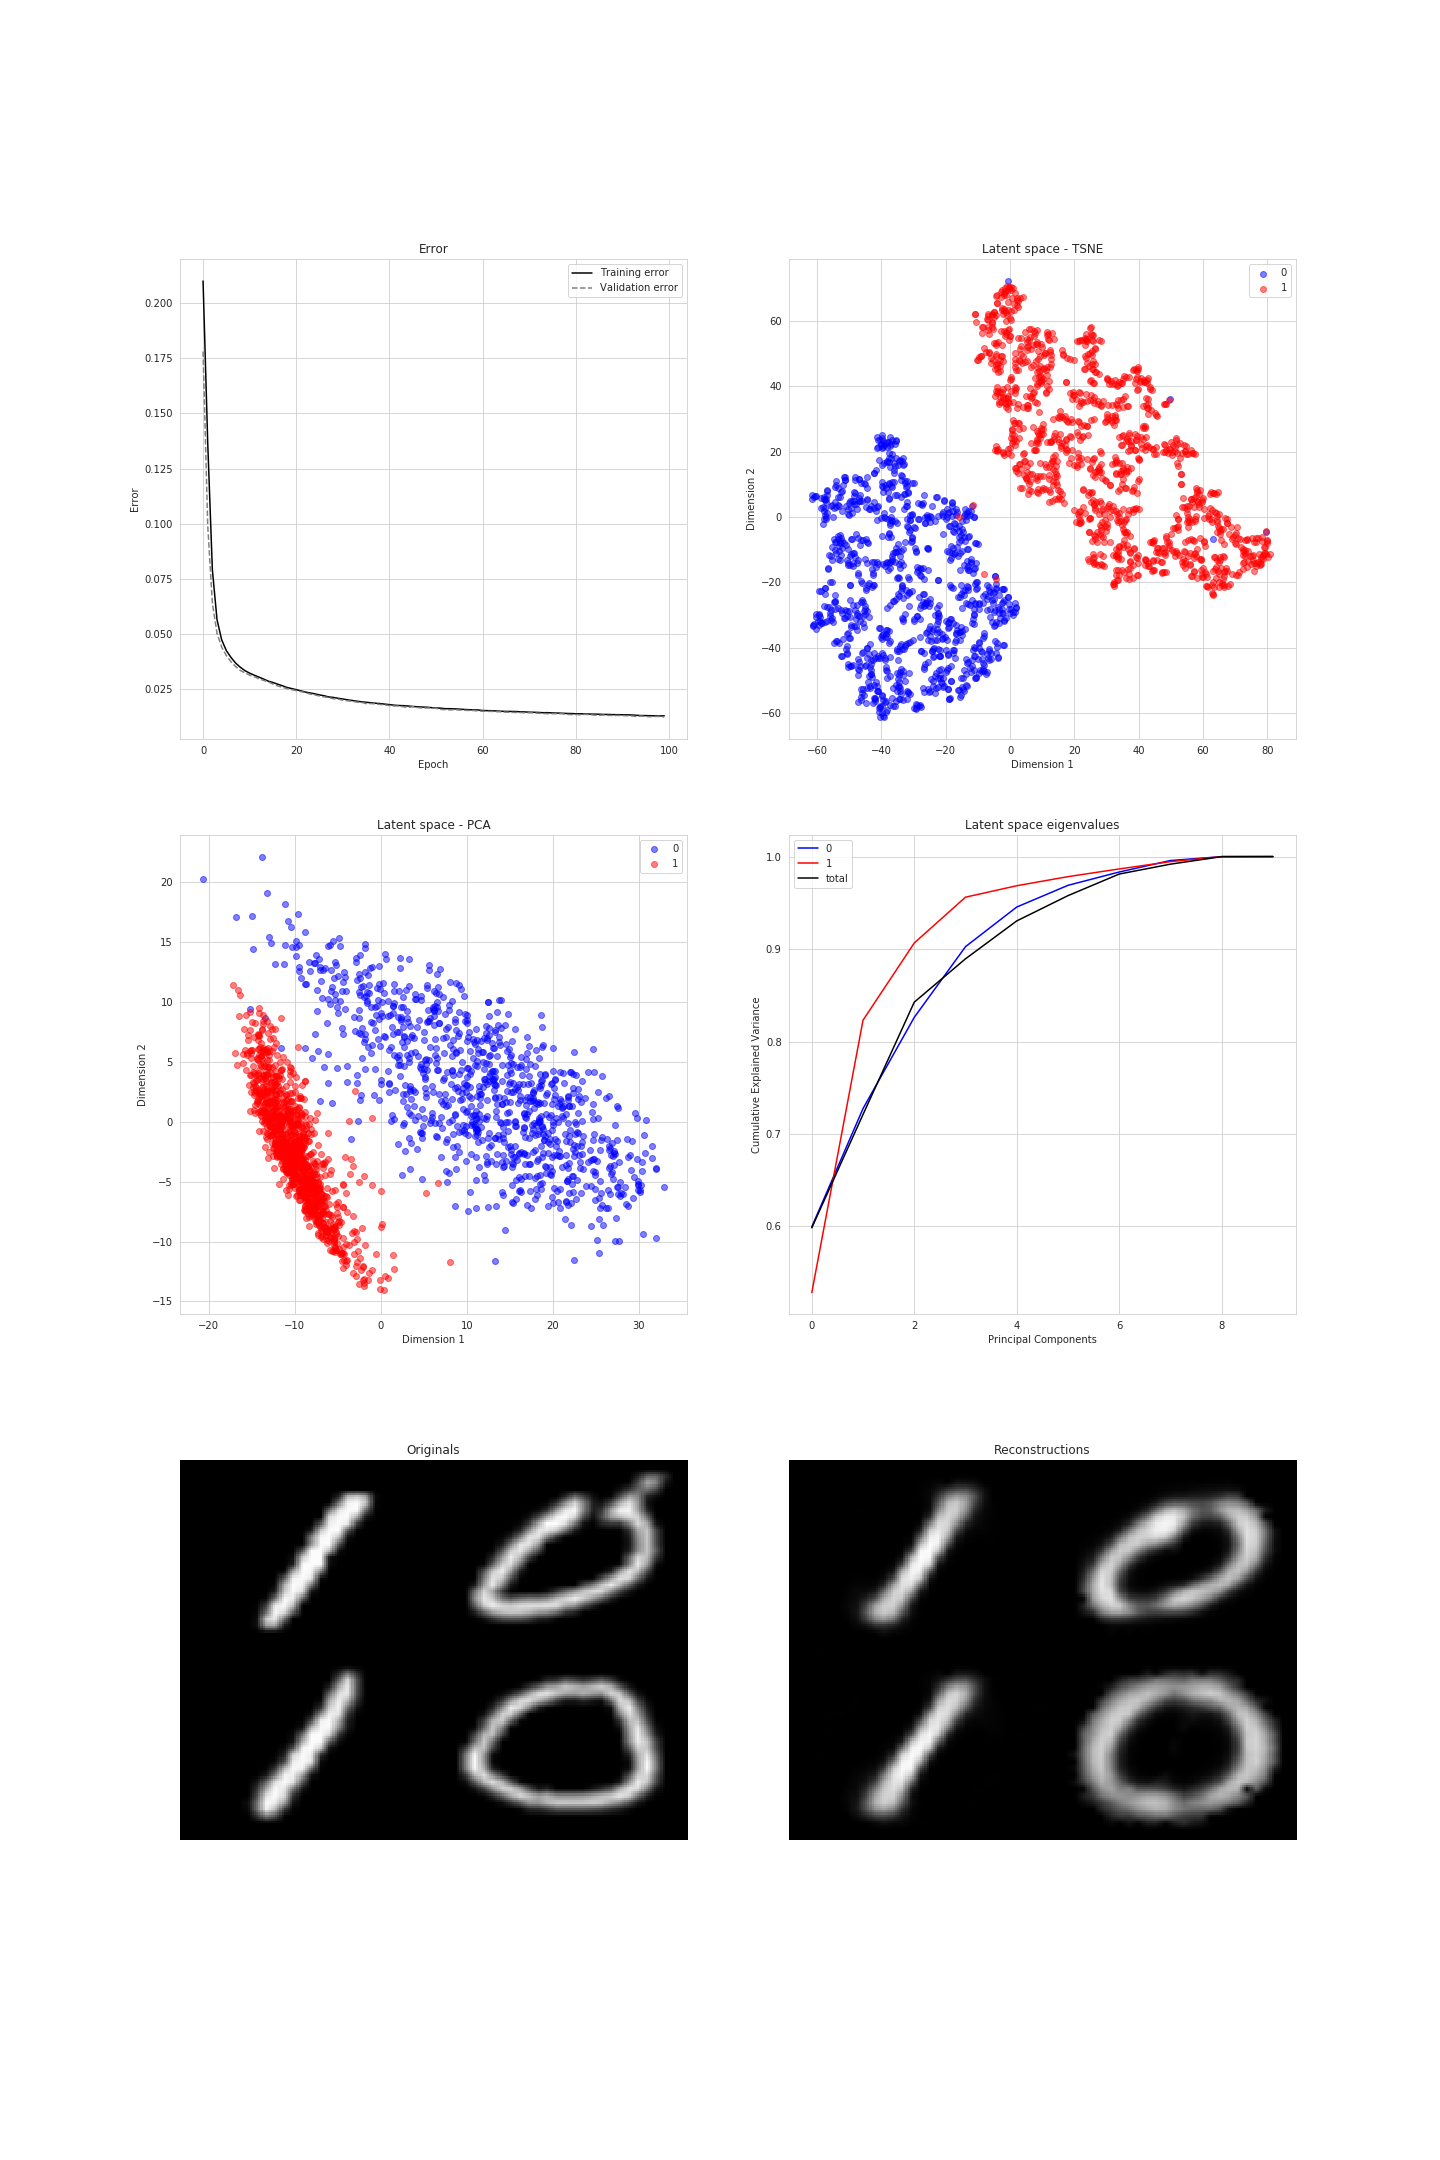

In [2]:
from imports import *
config = dict(modelName='SimplestAEMnist',
              modelParams=dict(imgSize=(28,28),
                               latent_features=10, 
                               in_channels=1, 
                               cuda=True ,
                               ),
                 max_num_epochs = 100,
                 suffix='_01',
                 opt='adam',
                 optParams = {'lr': 0.0005},
                 loss='mse',
                 batchSize=200,
                 earlyStopping=10,
                 imgSize=(28,28),
                 cuda=True,
                 save_me=True,
                 datagetter_name = 'mnist',
                 datagetterParams = dict(
                     background = 'black', 
                     #train_subset=2000,
                     #test_subset=200,
                     dataFilePath = '/home/rob/Dropbox/thesis/2. code/src/data/mnist.xlsx',
                     root = '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                     transforms = [('rotateandscale',{'rotation':1, 'scaling':0.1, 'background':'black'}),
                                   ('grayscale'),
                                   ('totensor')],
                     included_classes = [0,1],
                 ),
             )



ex = experiment(**config)
#ex.prep_experiment()
#ex.test_experiment()
ex.run_experiment()

In [14]:
from bokeh.plotting import figure, show, output_file, output_notebook
from itertools import combinations
import matplotlib
output_notebook()
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
#ground truth scores
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score, fowlkes_mallows_score
#scores that don't need ground truth
from sklearn.metrics import silhouette_score, davies_bouldin_score #, calinski_harabasz_score

sup_score_dict = {
    'arand': adjusted_rand_score,
    'ami': adjusted_mutual_info_score,
    'nmi': normalized_mutual_info_score,
    'homo': homogeneity_score,
    'comp': completeness_score,
    'v': v_measure_score,
    'fowl': fowlkes_mallows_score
}
unsup_score_dict = {
    'sil': silhouette_score,
    'dav': davies_bouldin_score    
}
cluster_dict = {
    'kmeans': KMeans,
    'agg': AgglomerativeClustering,
    'dbscan': DBSCAN,
    'optics': OPTICS
}


combos = list(combinations([0,1,2,3,4,5,6,7,8,9],2))
combos = [str(combo[0])+str(combo[1]) for combo in combos]
index = combos
columns =  list(sup_score_dict.keys()) + list(unsup_score_dict.keys())
res = pd.DataFrame(columns = columns, index=index)

Loading BokehJS ...

In [15]:
fps = glob('experiments/*2019-07-13_SimplestAEMnist_*.pth.tar')
for fp in tqdm(fps):
    ex = load_experiment(fp)
    combo = fp.split('_')[-1].split('.')[0]
    
    z_train, y_train, z_valid, y_valid = ex.results['z_train'],ex.results['y_train'],ex.results['z_valid'],ex.results['y_valid']
    num_samples = 1
    n_train, d = z_train.shape
    n_valid, d = z_valid.shape

    sample_number = 0
    z_clust = z_valid.reshape(-1,num_samples,d)[:,sample_number,:].copy()
    y_clust = np.array(y_valid).reshape(-1,num_samples)[:,sample_number].copy()    
    

    for clust_name in ['kmeans']:
        n_clusters = 2
        clust = cluster_dict[clust_name]()
        if hasattr(clust, 'n_clusters'):
            clust = cluster_dict[clust_name](n_clusters=n_clusters)

        if clust_name == 'dbscan':
            clust = DBSCAN(min_samples=100,eps=7)
        elif clust_name == 'optics':
            clust = OPTICS(min_samples = 100, xi=0.01)

        y_valid_pred = clust.fit_predict(z_clust)

        if not hasattr(clust, 'n_clusters'):
            n_clusters = len(np.unique(clust.labels_))

        res.loc[combo,'n_clusters'] = n_clusters

        for sup_score_name in sup_score_dict:
            print(sup_score_name)
            sup_score = sup_score_dict[sup_score_name](y_clust, y_valid_pred)
            res.loc[combo,sup_score_name] = sup_score
        for unsup_score_name in unsup_score_dict:
            print(unsup_score_name)
            if n_clusters >=2:
                unsup_score = unsup_score_dict[unsup_score_name](z_clust, y_valid_pred)
                res.loc[combo,unsup_score_name] = unsup_score

        

  0%|          | 0/46 [00:00<?, ?it/s]

=> loading checkpoint 'experiments/0.99_0.99_mse_001578_2019-07-13_SimplestAEMnist_17.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (1, 7),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': True,
                 'imgSize': (28, 28

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
  2%|▏         | 1/46 [00:00<00:26,  1.72it/s]

dav
=> loading checkpoint 'experiments/0.98_0.99_mse_003442_2019-07-13_SimplestAEMnist_26.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (2, 6),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': True,
                 'imgSize': (28

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
  4%|▍         | 2/46 [00:01<00:26,  1.67it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.98_0.98_mse_003092_2019-07-13_SimplestAEMnist_27.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (2, 7),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
  7%|▋         | 3/46 [00:01<00:25,  1.71it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.99_0.99_mse_002042_2019-07-13_SimplestAEMnist_15.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (1, 5),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
  9%|▊         | 4/46 [00:02<00:23,  1.76it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.98_0.99_mse_002749_2019-07-13_SimplestAEMnist_59.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (5, 9),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 11%|█         | 5/46 [00:02<00:23,  1.73it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/1.00_1.00_mse_001887_2019-07-13_SimplestAEMnist_16.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (1, 6),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 13%|█▎        | 6/46 [00:03<00:22,  1.75it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.99_0.99_mse_003790_2019-07-13_SimplestAEMnist_02.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (0, 2),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 15%|█▌        | 7/46 [00:04<00:23,  1.69it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.97_0.98_mse_002803_2019-07-13_SimplestAEMnist_56.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (5, 6),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 17%|█▋        | 8/46 [00:04<00:21,  1.79it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.93_0.93_mse_002348_2019-07-13_SimplestAEMnist_49.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (4, 9),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 20%|█▉        | 9/46 [00:05<00:21,  1.71it/s]

dav
=> loading checkpoint 'experiments/0.98_0.97_mse_002908_2019-07-13_SimplestAEMnist_47.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (4, 7),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': True,
                 'imgSize': (28

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 22%|██▏       | 10/46 [00:05<00:20,  1.76it/s]

dav
=> loading checkpoint 'experiments/0.98_0.99_mse_002532_2019-07-13_SimplestAEMnist_78.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (7, 8),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': True,
                 'imgSize': (28

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 24%|██▍       | 11/46 [00:06<00:20,  1.69it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/1.00_1.00_mse_002597_2019-07-13_SimplestAEMnist_04.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (0, 4),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 26%|██▌       | 12/46 [00:06<00:19,  1.75it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.96_0.95_mse_002624_2019-07-13_SimplestAEMnist_79.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (7, 9),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 28%|██▊       | 13/46 [00:07<00:18,  1.82it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.99_0.99_mse_003158_2019-07-13_SimplestAEMnist_07.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (0, 7),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 30%|███       | 14/46 [00:08<00:18,  1.76it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/1.00_1.00_mse_002256_2019-07-13_SimplestAEMnist_03.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (0, 3),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 33%|███▎      | 15/46 [00:08<00:16,  1.82it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.98_0.99_mse_003469_2019-07-13_SimplestAEMnist_29.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (2, 9),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 35%|███▍      | 16/46 [00:09<00:17,  1.72it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/1.00_1.00_mse_001598_2019-07-13_SimplestAEMnist_01.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (0, 1),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 37%|███▋      | 17/46 [00:09<00:16,  1.74it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.98_0.99_mse_002374_2019-07-13_SimplestAEMnist_46.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (4, 6),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 39%|███▉      | 18/46 [00:10<00:16,  1.69it/s]

dav
=> loading checkpoint 'experiments/0.99_0.99_mse_002903_2019-07-13_SimplestAEMnist_05.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (0, 5),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': True,
                 'imgSize': (28

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 41%|████▏     | 19/46 [00:10<00:14,  1.80it/s]

dav
=> loading checkpoint 'experiments/1.00_0.99_mse_002753_2019-07-13_SimplestAEMnist_34.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (3, 4),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': True,
                 'imgSize': (28

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 43%|████▎     | 20/46 [00:11<00:14,  1.74it/s]

dav
=> loading checkpoint 'experiments/1.00_1.00_mse_002635_2019-07-13_SimplestAEMnist_36.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (3, 6),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': True,
                 'imgSize': (28

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 46%|████▌     | 21/46 [00:11<00:13,  1.81it/s]

dav
=> loading checkpoint 'experiments/0.97_0.98_mse_002692_2019-07-13_SimplestAEMnist_35.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (3, 5),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': True,
                 'imgSize': (28

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 48%|████▊     | 22/46 [00:12<00:13,  1.78it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/1.00_0.99_mse_001664_2019-07-13_SimplestAEMnist_14.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (1, 4),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 50%|█████     | 23/46 [00:13<00:12,  1.80it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.98_0.99_mse_003508_2019-07-13_SimplestAEMnist_45.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (4, 5),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 52%|█████▏    | 24/46 [00:13<00:11,  1.87it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.97_0.98_mse_003264_2019-07-13_SimplestAEMnist_28.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (2, 8),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 54%|█████▍    | 25/46 [00:14<00:11,  1.81it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.99_0.99_mse_002802_2019-07-13_SimplestAEMnist_08.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (0, 8),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 57%|█████▋    | 26/46 [00:14<00:10,  1.87it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.98_0.98_mse_002935_2019-07-13_SimplestAEMnist_23.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (2, 3),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 59%|█████▊    | 27/46 [00:15<00:10,  1.80it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.97_0.97_mse_002483_2019-07-13_SimplestAEMnist_39.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (3, 9),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 61%|██████    | 28/46 [00:15<00:09,  1.83it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.98_0.98_mse_002884_2019-07-13_SimplestAEMnist_06.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (0, 6),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 63%|██████▎   | 29/46 [00:16<00:09,  1.78it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.99_0.99_mse_002631_2019-07-13_SimplestAEMnist_09.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (0, 9),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 65%|██████▌   | 30/46 [00:16<00:08,  1.84it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.99_0.99_mse_002419_2019-07-13_SimplestAEMnist_37.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (3, 7),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 67%|██████▋   | 31/46 [00:17<00:08,  1.74it/s]

dav
=> loading checkpoint 'experiments/0.99_0.99_mse_002744_2019-07-13_SimplestAEMnist_68.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (6, 8),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': True,
                 'imgSize': (28

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 70%|██████▉   | 32/46 [00:18<00:07,  1.81it/s]

dav
=> loading checkpoint 'experiments/0.99_0.99_mse_002264_2019-07-13_SimplestAEMnist_12.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (1, 2),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': True,
                 'imgSize': (28

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 72%|███████▏  | 33/46 [00:18<00:07,  1.70it/s]

dav
=> loading checkpoint 'experiments/1.00_1.00_mse_001210_2019-07-13_SimplestAEMnist_19.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (1, 9),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': True,
                 'imgSize': (28

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 74%|███████▍  | 34/46 [00:19<00:06,  1.73it/s]

dav
=> loading checkpoint 'experiments/0.97_0.98_mse_003013_2019-07-13_SimplestAEMnist_58.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (5, 8),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': True,
                 'imgSize': (28

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 76%|███████▌  | 35/46 [00:19<00:05,  1.84it/s]

dav
=> loading checkpoint 'experiments/0.98_0.98_mse_003270_2019-07-13_SimplestAEMnist_48.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (4, 8),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': True,
                 'imgSize': (28

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 78%|███████▊  | 36/46 [00:20<00:05,  1.80it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.97_0.97_mse_003007_2019-07-13_SimplestAEMnist_89.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (8, 9),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 80%|████████  | 37/46 [00:20<00:05,  1.75it/s]

Checkpoint results:
Avg Epoch Duration: 0 days 00:00:02.497466
Date: 2019-07-13
Best Validation Loss: 0.030065147806404218
Latest Train Loss: 0.030304231286301452
Latest Valid Loss: 0.030065147806404218
=> loaded checkpoint 'experiments/0.97_0.97_mse_003007_2019-07-13_SimplestAEMnist_89.pth.tar'
arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.99_0.99_mse_001934_2019-07-13_SimplestAEMnist_18.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (1, 8),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 83%|████████▎ | 38/46 [00:21<00:04,  1.72it/s]

dav
=> loading checkpoint 'experiments/0.99_0.99_mse_001722_2019-07-13_SimplestAEMnist_13.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (1, 3),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': True,
                 'imgSize': (28

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 85%|████████▍ | 39/46 [00:22<00:04,  1.62it/s]

fowl
sil
dav
=> loading checkpoint 'experiments/0.97_0.96_mse_002864_2019-07-13_SimplestAEMnist_38.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (3, 8),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': True,
                 'imgS

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 87%|████████▋ | 40/46 [00:22<00:03,  1.71it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.99_0.99_mse_003251_2019-07-13_SimplestAEMnist_57.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (5, 7),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 89%|████████▉ | 41/46 [00:23<00:02,  1.76it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.97_0.97_mse_004356_2019-07-13_SimplestAEMnist_25.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (2, 5),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 91%|█████████▏| 42/46 [00:23<00:02,  1.74it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/1.00_0.99_mse_001726_2019-07-13_SimplestAEMnist_13.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (1, 3),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 93%|█████████▎| 43/46 [00:24<00:01,  1.71it/s]

arand
ami
nmi
homo
comp
v
fowl
sil
dav
=> loading checkpoint 'experiments/0.98_0.98_mse_003745_2019-07-13_SimplestAEMnist_24.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (2, 4),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': Tr

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 96%|█████████▌| 44/46 [00:25<00:01,  1.68it/s]

dav
=> loading checkpoint 'experiments/1.00_1.00_mse_002296_2019-07-13_SimplestAEMnist_67.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (6, 7),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': True,
                 'imgSize': (28

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
 98%|█████████▊| 45/46 [00:25<00:00,  1.76it/s]

dav
=> loading checkpoint 'experiments/0.99_1.00_mse_002824_2019-07-13_SimplestAEMnist_69.pth.tar'
{'batchSize': 200,
 'cuda': True,
 'datagetterParams': {'background': 'black',
                      'dataFilePath': '/home/rob/Dropbox/thesis/2. '
                                      'code/src/data/mnist.xlsx',
                      'included_classes': (6, 9),
                      'root': '/home/rob/Dropbox/thesis/2. code/datasets/mnist',
                      'transforms': [('rotateandscale',
                                      {'background': 'black',
                                       'rotation': 1,
                                       'scaling': 0.1}),
                                     'grayscale',
                                     'totensor']},
 'datagetter_name': 'mnist',
 'denoise': False,
 'earlyStopping': 50,
 'imgSize': (28, 28),
 'loss': 'mse',
 'max_num_epochs': 50,
 'modelName': 'SimplestAEMnist',
 'modelParams': {'cuda': True,
                 'imgSize': (28

/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
100%|██████████| 46/46 [00:26<00:00,  1.67it/s]

v
fowl
sil
dav


In [26]:
res.index.name = 'numbers'
res.drop('n_clusters',axis=1).sort_values('arand').to_csv('mnist_combos.csv')

In [28]:
res.sort_values('arand')

,arand,ami,nmi,homo,comp,v,fowl,sil,dav,n_clusters
numbers,,,,,,,,,,
68,-0.000516217,-0.000373479,3.38052e-07,3.3784e-07,3.38263e-07,3.38052e-07,0.499951,0.279057,1.31833,2.0
29,-0.000484254,-0.000353787,6.3224e-08,6.29776e-08,6.34714e-08,6.32235e-08,0.502263,0.253867,1.46391,2.0
12,-0.000455588,-0.000330272,2.95902e-06,2.9614e-06,2.95665e-06,2.95902e-06,0.500115,0.221535,1.68282,2.0
07,-0.000176678,-0.000112419,0.000247275,0.000247275,0.000247275,0.000247275,0.499948,0.274476,1.39127,2.0
47,2.62441e-05,3.98008e-05,0.000399099,0.00039907,0.000399127,0.000399099,0.500076,0.310399,1.21343,2.0
34,0.000346403,0.000277792,0.000640565,0.000640139,0.000640992,0.000640565,0.500482,0.24269,1.49447,2.0
38,0.00340462,0.00258169,0.00294907,0.0029447,0.00295344,0.00294906,0.502635,0.2951,1.25356,2.0
36,0.00484743,0.00332604,0.00369766,0.00369182,0.0037035,0.00369765,0.503603,0.260212,1.4163,2.0
27,0.0058578,0.00426971,0.00462774,0.00461864,0.00463685,0.00462773,0.50404,0.227335,1.63958,2.0


In [4]:

z_train, y_train, z_valid, y_valid = ex.results['z_train'],ex.results['y_train'],ex.results['z_valid'],ex.results['y_valid']
num_samples = 1
n_train, d = z_train.shape
n_valid, d = z_valid.shape

sample_number = 0
z_clust = z_valid.reshape(-1,num_samples,d)[:,sample_number,:].copy()
y_clust = np.array(y_valid).reshape(-1,num_samples)[:,sample_number].copy()

z_plot = z_clust.copy()
y_plot = np.array(y_clust).copy()
tsne = TSNE(n_components=2, perplexity=5)
z_tsne = tsne.fit_transform(z_plot)

In [35]:
from bokeh.plotting import figure, show, output_file, output_notebook
import matplotlib
output_notebook()
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
#ground truth scores
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score, fowlkes_mallows_score
#scores that don't need ground truth
from sklearn.metrics import silhouette_score, davies_bouldin_score #, calinski_harabasz_score


sup_score_dict = {
    'arand': adjusted_rand_score,
    'ami': adjusted_mutual_info_score,
    'nmi': normalized_mutual_info_score,
    'homo': homogeneity_score,
    'comp': completeness_score,
    'v': v_measure_score,
    'fowl': fowlkes_mallows_score
}
unsup_score_dict = {
    'sil': silhouette_score,
    'dav': davies_bouldin_score    
}
cluster_dict = {
    'kmeans': KMeans,
    'agg': AgglomerativeClustering,
    'dbscan': DBSCAN,
    'optics': OPTICS
}

index = list(cluster_dict.keys())
columns = ['n_clusters'] + list(sup_score_dict.keys()) + list(unsup_score_dict.keys())
res = pd.DataFrame(columns = columns, index=index)

for clust_name in cluster_dict:
    n_clusters = 2
    clust = cluster_dict[clust_name]()
    if hasattr(clust, 'n_clusters'):
        clust = cluster_dict[clust_name](n_clusters=n_clusters)
    print(clust_name)
    
    if clust_name == 'dbscan':
        clust = DBSCAN(min_samples=100,eps=7)
    elif clust_name == 'optics':
        clust = OPTICS(min_samples = 100, xi=0.01)

    y_valid_pred = clust.fit_predict(z_clust)
    
    if not hasattr(clust, 'n_clusters'):
        n_clusters = len(np.unique(clust.labels_))
    
    res.loc[clust_name,'n_clusters'] = n_clusters
    
    for sup_score_name in sup_score_dict:
        print(sup_score_name)
        sup_score = sup_score_dict[sup_score_name](y_clust, y_valid_pred)
        res.loc[clust_name,sup_score_name] = sup_score
    for unsup_score_name in unsup_score_dict:
        print(unsup_score_name)
        if n_clusters >=2:
            unsup_score = unsup_score_dict[unsup_score_name](z_clust, y_valid_pred)
            res.loc[clust_name,unsup_score_name] = unsup_score




    y_plot_pred = np.array(y_valid_pred).copy()

    classes = np.unique(y_plot)
    colors = list(matplotlib.colors.CSS4_COLORS.keys())#['blue','red','green','yellow','purple','pink','black','brown','purple','cyan']
    colors = np.random.permutation(colors)

    p = figure(title = "Actual")
    p.xaxis.axis_label = '1'
    p.yaxis.axis_label = '2'

    for i in range(len(classes)):
        a = z_tsne[y_plot == classes[i]].T
        p.circle(a[0],a[1],color=colors[i], fill_alpha=0.2, size=10)

    for i in range(len(classes)):
        a = z_tsne[y_plot == classes[i]].T
        p.circle(a[0],a[1],color=colors[i], fill_alpha=0.2, size=10)

    show(p)

    classes = np.unique(y_plot_pred)
    p = figure(title = clust_name)
    p.xaxis.axis_label = '1'
    p.yaxis.axis_label = '2'

    for i in range(len(classes)):
        a = z_tsne[y_plot_pred == classes[i]].T
        p.circle(a[0],a[1],color=colors[i], fill_alpha=0.2, size=10)

    for i in range(len(classes)):
        a = z_tsne[y_plot_pred == classes[i]].T
        p.circle(a[0],a[1],color=colors[i], fill_alpha=0.2, size=10)

    show(p)
        

Loading BokehJS ...

kmeans
arand
ami
nmi
homo
comp
v
fowl
sil


/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


dav


agg
arand
ami
nmi
homo
comp
v
fowl
sil


/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


dav


dbscan
arand
ami
nmi
homo
comp
v
fowl
sil


/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


dav


optics
arand
ami
nmi
homo
comp
v
fowl
sil
dav


/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/rob/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [36]:
res

,n_clusters,arand,ami,nmi,homo,comp,v,fowl,sil,dav
kmeans,2,0.631398,0.58271,0.598213,0.582853,0.613977,0.59801,0.823212,0.43482,0.945517
agg,2,0.988679,0.971801,0.971811,0.971811,0.971811,0.971811,0.994367,0.390749,1.08457
dbscan,2,0.942203,0.902843,0.904001,0.905127,0.902876,0.904,0.971195,0.378913,1.11053
optics,2,0.969954,0.936052,0.936367,0.936074,0.936661,0.936367,0.985057,0.392584,1.08019


In [15]:
len(classes)

36

In [14]:
i

10

In [8]:
a[0]

array([63.974724, 62.533005, 63.177406, 63.144566, 60.504353, 64.40708 ],
      dtype=float32)

In [34]:
clust = OPTICS(min_samples = 100, xi=0.01)
clust.fit(z_valid)
np.mean(clust.labels_ == -1), len(np.unique(clust.labels_))

(0.46052009456264775, 2)

array([-1])

In [26]:
y_plot_pred

array([0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1], dtype=int32)

In [29]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from bokeh.plotting import figure, show, output_file, output_notebook

output_notebook()

num_samples = 10
n_train, d = z_train.shape
n_valid, d = z_valid.shape

sample_number = 0
z_plot = z_valid.reshape(-1,num_samples,d)[:,sample_number,:].copy()
y_plot = np.array(y_valid).reshape(-1,num_samples)[:,sample_number].copy()
y_plot_pred = np.array(y_valid_pred).reshape(-1,num_samples)[:,sample_number].copy()

classes = np.unique(y_plot)
colors = ['blue','red','green','yellow','purple','pink','black','brown','purple','cyan']

tsne = TSNE(n_components=2, perplexity=5)
z_tsne = tsne.fit_transform(z_plot)
p = figure(title = "Iris Morphology")
p.xaxis.axis_label = 'Petal Length'
p.yaxis.axis_label = 'Petal Width'

for i in range(len(classes)):
    a = z_tsne[y_plot == classes[i]].T
    p.circle(a[0],a[1],color=colors[i], fill_alpha=0.2, size=10)
    
for i in range(len(classes)):
    a = z_tsne[y_plot == classes[i]].T
    p.circle(a[0],a[1],color=colors[i], fill_alpha=0.2, size=10)

show(p)

classes = np.unique(y_plot_pred)
p = figure(title = "Iris Morphology")
p.xaxis.axis_label = 'Petal Length'
p.yaxis.axis_label = 'Petal Width'

for i in range(len(classes)):
    a = z_tsne[y_plot_pred == classes[i]].T
    p.circle(a[0],a[1],color=colors[i], fill_alpha=0.2, size=10)
    
for i in range(len(classes)):
    a = z_tsne[y_plot_pred == classes[i]].T
    p.circle(a[0],a[1],color=colors[i], fill_alpha=0.2, size=10)

show(p)

Loading BokehJS ...

In [ ]:

n = 300
z_plot = ex.z_valid.reshape(-1,10,100)[:,0,:].copy()
y_plot = np.array(ex.y_valid).reshape(1000,10)[:,0].copy()
indices = list(range(0,z_plot.shape[0]))
#np.random.shuffle(indices)
z_plot = z_plot[indices[:n]]
y_plot = y_plot[indices[:n]]
classes = np.unique(y_plot)
colors = ['blue','red','green','yellow','purple','pink','black','brown','purple','cyan']


#colormap = {'setosa': 'red', 'versicolor': 'green', 'virginica': 'blue'}
#colors = [colormap[x] for x in flowers['species']]

tsne = TSNE(n_components=2, perplexity=5)
z_tsne = tsne.fit_transform(z_plot)
p = figure(title = "Iris Morphology")
p.xaxis.axis_label = 'Petal Length'
p.yaxis.axis_label = 'Petal Width'

for i in range(len(classes)):
    a = z_tsne[y_plot == classes[i]].T
    p.circle(a[0],a[1],color=colors[i], fill_alpha=0.2, size=10)
    
for i in range(len(classes)):
    a = z_tsne[y_plot == classes[i]].T
    p.circle(a[0],a[1],color=colors[i], fill_alpha=0.2, size=10)

#output_file("a.html", title="iris.py example")
show(p)

In [3]:
from models.modelUtils import make_orthogonal_GMM
a,b,c = make_orthogonal_GMM(30,3,1,True)
a.shape,b.shape,c.shape

torch.Size([1, 3]) torch.Size([1, 3, 1, 30]) torch.Size([1, 3, 1, 30])


(torch.Size([1, 3]), torch.Size([1, 3, 1, 30]), torch.Size([1, 3, 1, 30]))